## 本課程由成大與台南二中共同開發的人工智慧高中教材改編

# 實作範例 2.2 - 特徵標準化與選擇 Feature Normalization and Selection

在 2.1 時我們介紹了 pandas 的基礎應用與尋找及補上缺失值，本範例中我們要繼續介紹幾個關於前處理的技巧：包括特徵的標準化、正規化與選擇等，經過適當處理與選擇的特徵可以很輕易地提昇模型的效率。最後我們以一個實際範例來介紹利用 **scikit-learn** 進行實際的模型建立與預測。

* **使用到的 Python 套件**：除了上一節介紹的 pandas 與 NumPy 外，本節主要使用 **[scikit-learn](https://scikit-learn.org/stable/)** 與  **[matplotlib](https://matplotlib.org/)** 套件。matplotlib 套件是 Python 的繪圖套件，可以將我們透過 Python 將資料以圖表的方式呈現出來，達到*資料視覺化 (Data Visualization)*的目的，並有助於使用者更容易地理解資料。
* **安裝 Python 套件**：與上一節介紹的相同，除了透過 [Anaconda](https://www.anaconda.com/distribution/) 外，也可以利用 [pip](https://pypi.org/project/pip/) 進行安裝：
```
pip install scikit-learn
pip install matplotlib
```
* **所使用的資料集**：本節實作範例包含一個 JSON 資料檔 `hero_data.json`，作為教學與練習範例，請將之與本教學文件*放在同一資料夾*下。

首先我們先載入本範例中所有會使用到的套件與模組：

In [2]:
import pandas as pd # 載入 pandas
import numpy as np # 載入 NumPy
import matplotlib.pyplot as plt # 載入 Matplotlib
from sklearn import preprocessing # 載入 scikit-learn 的 preprocessing 模組
from sklearn.metrics.pairwise import euclidean_distances # 載入(以歐幾里得距離)計算特徵距離的模組
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier # 載入極限隨機樹模組
from sklearn.svm import LinearSVC # 載入 LinearSVC 模組做特徵選擇
from sklearn.model_selection import train_test_split # 載入資料分割模組
from sklearn.model_selection import cross_val_score # 載入交叉驗證模組
from sklearn.neighbors import KNeighborsClassifier # 載入 kNN 分類器

## 特徵的標準化 Feature Normalization

假設今天有一筆有三個特徵的資料：身高、體重與視力，而今天我們要依照這三個特徵將人群分類，你會怎麼做呢？

還記得我們課堂教過的特徵距離計算嗎？對！其中一個方法就是計算每筆資料間的**特徵距離**（更精確的說是「[歐幾里得距離](https://zh.wikipedia.org/zh-tw/%E6%AC%A7%E5%87%A0%E9%87%8C%E5%BE%97%E8%B7%9D%E7%A6%BB)」），然後比較各資料點間的特徵距離。若資料間的特徵距離相近，可以將它們視為性質相近的資料點，較容易分在同一類；若資料點間的特徵距離較長，則視為性質較不相近的資料點，比較容易分在不同類。

但是，問題來了。身高、體重與視力的單位都不同啊！應該要怎麼計算特徵距離呢？如果我們單純只把單位拿掉計算，會發生什麼事呢？同學們可以想想看，身高 170 與 175 之間的差異與視力 0.1 及 1.2 之間的差異哪個比較巨大呢？從客觀角度而言，我想大部分的人都會覺得*視力*的差距比較巨大；但我們拿掉任何單位，單純從數字的角度來看，是不是就不一樣了呢？

這就是為什麼我們需要對特徵進行**標準化**，透過特徵的標準化，可以**讓每個特徵的資料點都落在某一特定的區間，消除掉因為不同特徵常因值域（單位）不同而造成在特徵距離的計算上比重不均的問題**。
 
常見的標準化有兩種：
* **Min-Max 標準化**
  - 將特徵數據按比例縮放到特定區間（0 到 1 或 -1 到 1）
  - Scikit-learn 中我們使用 `preprocessing.MinMaxScaler` 來實作
* **Z-score 標準化**
  - 將所有特徵數據縮放成平均為 0、標準差為 1
  - Scikit-learn 中我們使用 `preprocessing.StandardScaler` 來實作

我們接下來分別介紹在 Scikit-learn 中實作的方法：

### Min-Max 標準化（Min-Max Normalization）

Min-Max 標準化顧名思義就是將每個特徵的值域都縮放到特定的範圍 \[Min, Max\] 中，通常這個範圍我們會取 `[0, 1]` 或 `[-1, 1]`。

首先我們載入 scikit-learn 中的 `preprocessing` 模組：
```
from sklearn import preprocessing
```

然後把範例資料利用 matplotlib 的 `scatter()` 畫成散佈圖看看：

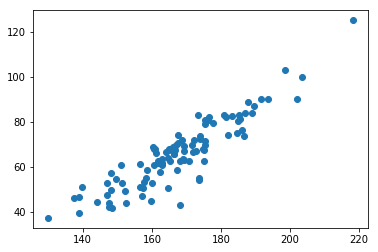

In [9]:
# 假設我們這邊有一組 100 筆資料的身高/體重資料...
body_data = [[164.58, 63.72], [146.94, 52.68], [169.43, 62.95], [172.62, 66.85], [198.44, 103.26], [218.12, 125.26], [144.1, 44.3], [174.83, 67.72], [139.75, 51.04], [167.23, 58.41], [175.14, 67.49], [175.47, 71.43], [183.32, 82.54], [167.03, 69.62], [169.16, 66.89], [162.86, 61.48], [147.67, 41.89], [165.0, 67.68], [130.07, 37.24], [169.02, 63.46], [164.94, 67.92], [161.85, 61.65], [160.67, 60.72], [157.03, 47.18], [166.09, 68.64], [160.33, 68.8], [177.63, 79.66], [165.13, 62.38], [162.25, 57.82], [172.07, 72.03], [147.53, 43.82], [171.51, 69.6], [152.53, 43.77], [161.87, 62.8], [203.36, 99.95], [185.06, 80.28], [158.35, 54.81], [164.13, 66.4], [170.65, 62.61], [175.38, 80.74], [182.14, 74.18], [186.93, 83.83], [168.01, 62.74], [138.96, 46.61], [166.61, 67.64], [166.36, 65.66], [160.81, 67.99], [189.51, 86.98], [175.49, 78.91], [184.63, 75.2], [173.35, 82.89], [148.42, 41.76], [167.59, 74.29], [188.97, 84.08], [159.74, 44.76], [162.96, 63.56], [148.27, 57.08], [152.21, 49.25], [160.56, 67.92], [187.89, 88.83], [176.5, 82.14], [175.29, 69.52], [173.51, 54.91], [166.44, 65.73], [151.47, 52.8], [176.3, 80.71], [160.05, 52.9], [157.51, 50.56], [164.73, 50.77], [161.31, 66.1], [176.32, 80.65], [168.58, 71.89], [202.03, 90.19], [181.37, 82.38], [158.71, 58.47], [167.56, 70.72], [157.77, 53.01], [138.79, 39.45], [156.58, 61.17], [171.97, 66.65], [173.94, 72.33], [156.49, 51.16], [191.45, 90.22], [180.94, 83.25], [146.89, 47.22], [186.07, 76.53], [193.64, 90.16], [151.02, 60.82], [163.03, 60.69], [137.48, 46.16], [168.1, 43.01], [174.04, 73.85], [148.1, 49.63], [185.55, 81.31], [169.33, 69.33], [185.28, 83.15], [186.79, 73.84], [175.16, 62.46], [149.62, 54.56], [173.72, 54.04]]
body_data = np.asarray(body_data) # 將 body_data 從 Python list 轉成 np.ndarray

# 我們先使用 matplotlib 將資料的分佈樣貌畫出來看看
# ndarray 選取欄位值 選取單一攔
# [:,2] 的意思是選擇「所有列」的 index 為「2」的元素，也就是 index 為 2 的那一欄
plt.scatter(body_data[:,0], body_data[:,1]) # plt.scatter(X, Y) 散點圖
plt.show()

如上圖，我們可以看到 x 軸上的身高分佈是從約 130 到近 220；而體重則是近 40 至約 120。

透過 matplotlib 的 `scatter()` 方法，我們可以很簡單地將資料點畫成**散佈圖**。`scatter()`內有兩個參數，分別是 x 軸與 y 軸，將資料匯入之後再使用 `show()` 函數，便可將圖秀出。（關於 `scatter()` 更詳細的參數說明，可以參考[官方的文件](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.scatter.html)）

然後我們利用 scikit-learn 的 `preprocessing.MinMaxScaler` 將值縮放到特定區間：

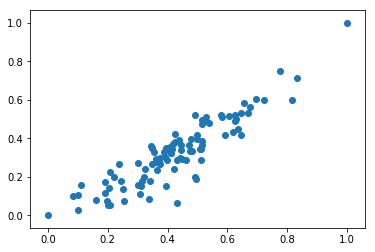

In [3]:
mmscaler = preprocessing.MinMaxScaler() # 建立一個 MinMaxScaler
mmscaler.fit(body_data) # 餵資料給這個 MinMaxScaler，自動計算要怎麼縮放資料
body_data_scaled = mmscaler.transform(body_data) # 將 body_data 依照上一步驟算出的結果縮放，並存到 body_data_scaled 變數中

# 然後畫出來看看！
plt.scatter(body_data_scaled[:,0], body_data_scaled[:,1])
plt.show()

我們可以比較看看上面兩張圖，有沒有發現它們的資料分布是一模一樣的呢？但是軸上的數字不一樣了！現在兩個軸的範圍都會在 0 至 1 之間了。

`MinMaxScaler` 的範圍預設是 \[0, 1\]，同時它也可以透過參數中的 `feature_range` 屬性給定。假設我們要一個縮放到 \[-1, 1\] 間的 `MinMaxScaler`，可以這樣寫：

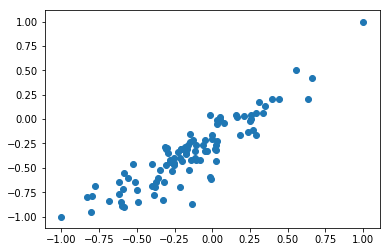

In [4]:
mmscaler = preprocessing.MinMaxScaler(feature_range=(-1, 1)) # 自訂值的範圍在 -1 至 1 之間
mmscaler.fit(body_data) 
body_data_scaled = mmscaler.transform(body_data)

plt.scatter(body_data_scaled[:,0], body_data_scaled[:,1])
plt.show()

這時候每個特徵的值範圍就會在 \[-1, 1\] 中了。

關於 `MinMaxScaler` 的詳細說明，請參考 scikit-learn 的[官方參考文件](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)。

### Z-score 標準化（Z-score Normalization）

除了前述的方法外，我們也能藉由將某個特徵的值**減去全體的平均值**，讓每個特徵的平均值變成 0，降低數值大小的影響。接著使用 [Z-score](https://zh.wikipedia.org/zh-tw/%E6%A8%99%E6%BA%96%E5%88%86%E6%95%B8)（標示著一個值距離其母體平均數多少個標準差）的概念，將特徵值**除以標準差**，讓資料中的值變為 Z-score，降低因不同特徵之不同離散程度而造成值的區間不同的影響。最後使讓每個特徵都呈現「**平均數為 0、且標準差為 1**」的型態。

在 scikit-learn 中，我們使用 `preprocessing.StandardScaler` 進行 Z-score 標準化：

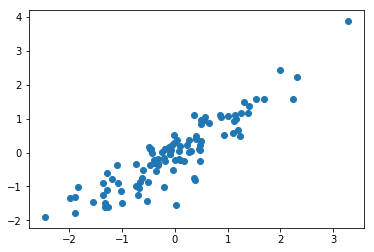

In [5]:
stdscaler = preprocessing.StandardScaler() # 建立一個 StandardScaler
stdscaler.fit(body_data) # 餵資料給這個 StandardScaler，自動計算要怎麼縮放資料
body_data_scaled = stdscaler.transform(body_data) # 將 body_data 依照上一步驟算出的結果縮放，並存到 body_data_scaled 變數中

# 然後一樣畫出來看看！
plt.scatter(body_data_scaled[:,0], body_data_scaled[:,1])
plt.show()

然後看看經過特徵縮放資料的平均數與標準差：

In [6]:
# 當axis=0時，代表每一 col 去做運算
# 當axis=1時，代表每一 row 去做運算

body_data_scaled.mean(axis=0)

array([ 7.25530747e-16, -4.18554080e-16])

In [7]:
body_data_scaled.std(axis=0)

array([1., 1.])

我們可以看到每個特徵的平均數都是非常接近 0 的數字（`e-16` 是指 $\times 10^{-16}$ 的意思），而標準差則都是 1。

關於 `StandardScaler` 的詳細說明，請參考 scikit-learn 的[官方參考文件](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)。

關於利用 Scikit-learn 進行特徵標準化，在官網有[更進一步的說明](https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling)。另外 Scikit-learn 官方也比較了[不同種特徵處理方法對異常值 (outliers) 的影響](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html)，有興趣的讀者可前往閱讀。

### 補充說明 1：Scikit-learn 進行前處理的步驟

Scikit-learn 的前處理大致可以分為三個流程：
* `建立 preprocessor` &rarr; `fit` &rarr; `transform`

我們上面的作法是將三個步驟都分開來做，但 scikit-learn 也提供了便捷的方法快速轉換：
* `fit_transform()`: 如果要 fit 及 transform 的資料都相同，可以直接使用該函式：
```
stdscaler = preprocessing.StandardScaler()
body_data_scaled = stdscaler.fit_transform(body_data)
```
* `scale()`: 直接進行以 `StandardScaler` 為基礎的特徵縮放：
```
body_data_scaled = preprocessing.scale(body_data)
```

以上兩段程式碼跟前面示範 `StandardScaler` 的程式碼都是*等價*的。可能有同學會問，既然有這麼方便的函式，為什麼我們要分開做呢？這是因為當我們實際在處理資料時（尤其是要評估演算法的好壞時），通常會將資料分為**訓練集**與**測試集**，我們會依照訓練集的資料來 fit，但 transform 測試集的資料，也就是 fit 跟 transform 的對象可能是不同的，這時候就要分開做囉。

事實上，scikit-learn 中大部分的模型訓練、預測等也都是遵循著這套作法，先依照訓練集的資料 fit() 模型，然後再利用 transform() 轉換目標資料、或是利用 predict() 預測。

### 補充說明 2：Scikit-learn 中計算特徵距離的方法

Scikit-learn 中提供了方便的函式計算特徵距離，以歐幾里得距離為例，我們可以使用 `sklearn.metrics.pairwise.euclidean_distances()` 計算。首先我們載入必要模組：
```
from sklearn.metrics.pairwise import euclidean_distances
```

然後我們看看範例：

In [0]:
euclidean_distances(body_data[:5], body_data[:5]) # 計算 body_data 前五筆資料間的特徵距離

array([[ 0.        , 20.80988227,  4.91074332,  8.62777492, 52.05680743],
       [20.80988227,  0.        , 24.72393577, 29.33004091, 72.18439166],
       [ 4.91074332, 24.72393577,  0.        ,  5.03846207, 49.66363056],
       [ 8.62777492, 29.33004091,  5.03846207,  0.        , 44.63586562],
       [52.05680743, 72.18439166, 49.66363056, 44.63586562,  0.        ]])

上面的範例中，`euclidean_distances()` 的第一與第二個參數分別就是放欲計算的資料點，然後 `euclidean_distances()` 會計算第一參數中所有資料點到第二個參數中所有資料點的距離。上面我們要計算 body_data 前五筆資料間的特徵距離，故我們在第一與二個參數中都放入相同的資料點，計算後出來的矩陣中，第一列代表*第一個參數中的第一個點*到*第二個參數中各個點*的距離。由於我們兩個參數的資料是相同的，因此同學們應該可以觀察到上面矩陣中的對角線都是 0，因為自己到自己，沒有距離。

若要計算到各點到原點的距離，可以如下使用：

In [0]:
euclidean_distances(body_data[:5], [[0.0, 0.0]]) # 計算 body_data 前五筆資料到原點的距離

array([[176.48460216],
       [156.09787314],
       [180.74630674],
       [185.1123629 ],
       [223.69859454]])

關於 `euclidean_distances()` 的詳細說明，請參考[官方網站](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.euclidean_distances.html)。

## 特徵選擇 Feature Selection

當我們的資料擁有許多特徵時，會讓計算的時間加長；而如此多的特徵，也不見得每一個都是有用的，過多的特徵也可能容易使演算法失準。當資料特徵的數量多到人工無法處理時，我們能**利用數學函式讓機器學習自行挑出最有影響力的特徵**，這也能作為**特徵降維**的手段來改善高維度數據的準確率。

Scikit-learn 中提供多種自動選擇特徵的方法，我們精選以下常用的做介紹：
* 移除低[變異數](https://zh.wikipedia.org/zh-tw/變異數)的特徵
* 單變數特徵選擇
* 利用模型選擇特徵

我們首先載入所需的資料集：

In [0]:
hero_data = pd.read_json("./hero_data.json") # 載入本練習的範例資料集 Hero_Data.json
hd = pd.DataFrame(hero_data, dtype=float) # 並將之轉為 pandas 的 DataFrame
hd # 看看資料集的內容

,攻擊力,攻擊成長,攻擊範圍,攻擊速度,攻速成長,生命值,生命成長,移動速度,護甲,護甲成長,魔抗成長,魔法抗性
0,60.000,2.800,0.0,0.669,2.70,585.0,85.0,340.0,29.000,3.30,1.25,32.100
1,62.000,3.500,0.0,0.635,1.90,510.0,85.0,335.0,24.000,3.90,0.00,30.000
2,56.000,2.200,1.0,0.625,2.06,545.0,80.0,325.0,24.000,3.00,0.00,30.000
3,55.000,3.000,0.0,0.625,2.50,400.0,65.0,345.0,26.000,4.00,1.25,32.100
4,50.000,3.000,0.0,0.625,2.80,580.0,74.0,330.0,22.000,3.50,1.25,30.000
5,50.000,3.000,0.0,0.625,2.80,580.0,74.0,330.0,22.000,3.50,1.25,30.000
6,56.000,3.300,0.0,0.625,1.12,500.0,75.0,325.0,20.000,3.00,0.00,30.000
7,57.000,3.200,1.0,0.625,1.00,550.0,80.0,325.0,19.000,3.60,0.00,30.000
8,53.000,3.100,1.0,0.625,0.00,540.0,85.0,325.0,20.000,3.50,0.00,30.000
9,60.000,5.000,0.0,0.571,2.50,585.6,95.0,340.0,26.000,3.80,1.25,32.100


可以看到這是一份包含 134 個英雄的資料，我們的目標是要利用這份資料預測英雄成長值，以分類攻擊範圍。也就是「攻擊範圍」是英雄的**類別**，而除了攻擊範圍外的所有欄位都是**特徵**，我們將示範如何使用 scikit-learn 挑選有用的特徵，然後透過簡單的 [kNN 演算法](https://zh.wikipedia.org/zh-tw/%E6%9C%80%E8%BF%91%E9%84%B0%E5%B1%85%E6%B3%95)驗證效果。

所以，我們先將這份資料分成「特徵」與「類別」兩部份：

In [0]:
hero_x = hd.drop(['攻擊範圍'], axis=1) # 選擇特徵，drop() 可以將一個 DataFrame 中的某欄位/列去掉
hero_y = hd['攻擊範圍'] # 選擇類別
hero_y = np.ravel(hero_y) # 把 hero_y 攤平並轉成 ndarray，方便後續計算與閱讀結果

接下來我們分別介紹幾種 scikit-learn 中選擇特徵的方法：

### 移除低變異數的特徵

變異數可以描述一個隨機變數（特徵）的離散程度，我們知道若一個特徵對結果的解釋力很大，該特徵對類別的相關係數會接近 1。一般情況下，若資料的類別分布平均（變異數較大），不大量偏向某一兩個類別（變異數較小）時，可以使用這個基本的方法篩選掉一些變異數過小的特徵，因為其對結果的解釋力通常不大。

Scikit-learn 中可以使用 `sklearn.feature_selection.VarianceThreshold` 來達成，首先載入必要模組：
```
from sklearn.feature_selection import VarianceThreshold
```

然後我們看看範例：

In [0]:
sel = VarianceThreshold(threshold=0.7) # 設定變異數的閾值，若特徵的變異數低於該值，該特徵就會被移除
x_sel = sel.fit_transform(hero_x) # 利用先前建立的 VarianceThreshold 來篩選 hero_x
x_sel.shape # 我們可以使用 ndarray 的 shape 屬性來檢視最後篩選剩多少個特徵

(134, 8)

我們可以看到篩選過後的 `X_sel` 變數的矩陣是 134 $\times$ 8，也就是 8 個特徵。相較於原先的 11 個特徵，篩選掉了 3 個。變異數閾值的設定基本上是按照資料而定，根據不同的資料特性而會有不同值。

另外，若建立 `VarianceThreshold` 時不設定 `threshold` 參數，預設會篩選掉所有變異數為零的欄位。

關於 `VarianceThreshold` 的詳細用法，請參考[官方的 API Reference](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html)。

### 單變數特徵選擇

單變數特徵選擇是根據每個變數（特徵）個別的單變數統計值作為門檻，然後依據該門檻選擇特徵。Scikit-learn 中提供了數種選擇特徵的方式與單變數統計值，我們這邊僅簡單介紹 `SelectKBest` 與 `chi2`。

`chi2` 是指[卡方統計值](https://zh.wikipedia.org/zh-tw/%E7%9A%AE%E7%88%BE%E6%A3%AE%E5%8D%A1%E6%96%B9%E6%AA%A2%E5%AE%9A)（$\chi^2$），該統計值能評估兩個隨機變數是否互相獨立，若該值愈大，該二隨機變數愈有機會是相關的，反之則為獨立（不相關）。

`SelectKBest` 顧名思義就是將每個特徵的統計值算出後，選出 $k$ 個最佳的特徵。

要使用以上功能需要先載入模組：
```
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

```

In [0]:
sel_chi2 = SelectKBest(chi2, k=5) # 指定以卡方統計值作為選擇依據，並選擇最佳的 5 個統計值作為特徵。
x_chi2 = sel_chi2.fit_transform(hero_x, hero_y) # 由於單變數特徵選擇必須將特徵與類別作比較，故除了 hero_x 外，也要納入 hero_y
x_chi2.shape

(134, 5)

我們可以看到篩選過後的特徵剛剛好就是 5 個。

關於單變數特徵選擇的詳細用法，請參考[官方的 User guide](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection)。

### 利用模型選擇特徵

Scikit-learn 也提供了從模型選擇變數的方法。該方法可以利用一個特定的模型（演算法）先對資料經過一次訓練，然後以該模型計算出的特徵重要性作為依據，挑選解釋力大的特徵。

首先載入必要模組：
```
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier # 載入極限隨機樹模組
from sklearn.svm import LinearSVC # 載入 LinearSVC 模組做特徵選擇
```

然後示範基於[極限隨機樹](https://zh.wikipedia.org/zh-tw/%E9%9A%8F%E6%9C%BA%E6%A3%AE%E6%9E%97#%E6%9E%81%E9%99%90%E6%A0%91)（類似於[隨機森林](https://zh.wikipedia.org/zh-tw/%E9%9A%8F%E6%9C%BA%E6%A3%AE%E6%9E%97)演算法，但有一點不同）模型來選擇特徵：

In [0]:
clf = ExtraTreesClassifier(n_estimators=50) # 決定決策數的數量
clf = clf.fit(hero_x, hero_y) # 訓練模型
print("特徵重要性：", clf.feature_importances_) # 模型訓練完後，可以得到一個評估各特徵重要性的矩陣，值愈大愈重要
print("特徵重要性平均值：", clf.feature_importances_.mean())

# 建立 SelectFromModel 選擇器，並載入剛剛訓練完的極限隨機樹，因為該模型已經過訓練，故要將 prefit 參數設為 True
model = SelectFromModel(clf, prefit=True) 
x_et = model.transform(hero_x) # 篩選 hero_x 的特徵
x_et.shape

特徵重要性： [0.1233199  0.05224575 0.03792044 0.06106462 0.1025699  0.06873137
 0.1467706  0.09480808 0.04040433 0.24694759 0.02521742]
特徵重要性平均值： 0.09090909090909091


(134, 5)

`SelectFromModel` 會從模型的 `feature_importances_` 或 `coef_` 兩個參數作為選擇特徵的依據，若沒有特別標明選擇的方式（`threshold` 參數），此例中會使用平均值作為門檻。我們能看到在訓練後的 11 個特徵中，有 5 個特徵超過了平均值，故最後選擇了 5 個特徵。

由於決策樹的生長是*隨機*的，故同學們重新執行此段程式後會發現結果可能*不同*，這是正常的。

接著示範利用基於[線性 SVM 分類器](https://zh.wikipedia.org/zh-tw/%E6%94%AF%E6%8C%81%E5%90%91%E9%87%8F%E6%9C%BA#%E7%BA%BF%E6%80%A7SVM)來選擇特徵：

In [0]:
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(hero_x, hero_y) # 利用 LSVC 訓練

model = SelectFromModel(lsvc, prefit=True)
x_lsvc = model.transform(hero_x)
x_lsvc.shape

/home/aitestware/.pyenv/versions/3.7.1/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


(134, 3)

可以看到選擇了 3 個特徵。

關於利用模型來選擇特徵的完整說明，有興趣的讀者可以參考[官方的 User guide](https://scikit-learn.org/stable/modules/feature_selection.html#feature-selection-using-selectfrommodel)。

## 測試特徵處理前後的效果

接著我們以 [k-最近鄰居演算法](https://zh.wikipedia.org/zh-tw/%E6%9C%80%E8%BF%91%E9%84%B0%E5%B1%85%E6%B3%95)來測試特徵選擇前後、以及利用不同方法選擇特徵對分類效果的影響。

首先載入會使用到的模組：
```
from sklearn.model_selection import train_test_split # 載入資料分割模組
from sklearn.model_selection import cross_val_score # 載入交叉驗證模組
from sklearn.neighbors import KNeighborsClassifier # 載入 kNN 分類器
```

我們使用 `sklearn.model_selection.train_test_split` 將資料隨機分割為「訓練集」與「測試集」。其用意在測試某個演算法的效果，透過先行訓練「訓練集」中的資料，再利用訓練完成的模型對「測試集」做分類/預測，再比較分類的結果與原始資料的類別，算出一個分數，評估該演算法的好壞。

另外，我們也能使用 `sklearn.model_selection.cross_val_score` 做模型的交叉驗證，透過**輪流**將「訓練集」切出一小部份作為「驗證集」，評估現在訓練中的模型的好壞。

所有測試均遵循以下步驟：
* `標準化資料` &rarr; `分割訓練集/測試集` &rarr; `以不同的鄰居數（k 值）對 KNN 作交叉驗證` &rarr; `利用表現最佳的 k 值預測` &rarr; `計算準確度`

我們開始吧！首先是沒有經過篩選的特徵：

### 未經篩選的特徵

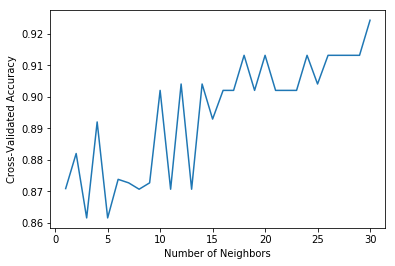

Using k = 30
預測結果： [1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1.]
實際答案： [1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.]
準確率： 0.7804878048780488


In [0]:
hero_x_scaled = preprocessing.scale(hero_x) # 先對特徵做標準化

# 資料分割，指定 30% 的資料作為測試集
x_train, x_test, y_train, y_test = train_test_split(hero_x_scaled, hero_y, test_size=0.3) 

# 以不同的鄰居數（範圍 1 ~ 30）對 KNN 作交叉驗證
k_range = range(1, 31)
k_scores = []
for k_number in k_range:
    knn = KNeighborsClassifier(n_neighbors=k_number)
    # 交叉驗證，指定做 10 輪（每次由不同的 1/10 的訓練集輪流作驗證集），並指定以準確率作為分數
    scores = cross_val_score(knn, x_train, y_train, cv=10, scoring='accuracy') 
    k_scores.append(scores.mean()) # 把每次更新鄰居數的準確率平均加進 k_scores，以便繪圖

# 把鄰居數與準確率的關係畫成圖
plt.plot(k_range, k_scores)
plt.xlabel('Number of Neighbors')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

# 尋找準確率最高的 k 值，若有同分的狀況，我們只找第一個
max_k = k_scores.index( max(k_scores) ) + 1

# 利用表現最佳的 k 值預測
knn = KNeighborsClassifier(n_neighbors=max_k).fit(x_train, y_train)
print("Using k =", max_k)
print("預測結果：", knn.predict(x_test)) # 利用測試集中的特徵預測
print("實際答案：", y_test) # 這是測試集中的實際答案
print("準確率：", knn.score(x_test, y_test))

可以看到我們挑了最高的 k = 30 作為測試用的參數，算出來的預測結果中，41 個值有 9 個值是預測錯誤的，準確率為 $\frac{41 - 9}{41} = 0.7804878048780488$。

要注意的一點是，因為訓練集/測試集、訓練集/驗證集都是隨機分割的，故同學們在重新執行這段程式碼時，可能會發現*結果不一樣*，這是正常的唷。

以下將使用同樣的作法測試。

### 去除低變異數的特徵 

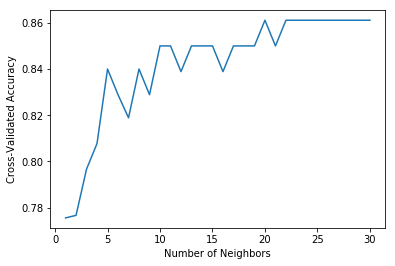

Using k = 20
預測結果： [0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.
 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1.]
實際答案： [0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0.
 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.]
準確率： 0.8536585365853658


In [0]:
x_sel = preprocessing.scale(x_sel)
x_train, x_test, y_train, y_test = train_test_split(x_sel, hero_y, test_size=0.3) 

k_range = range(1, 31)
k_scores = []
for k_number in k_range:
    knn = KNeighborsClassifier(n_neighbors=k_number)
    scores = cross_val_score(knn, x_train, y_train, cv=10, scoring='accuracy') 
    k_scores.append(scores.mean())

plt.plot(k_range, k_scores)
plt.xlabel('Number of Neighbors')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

max_k = k_scores.index( max(k_scores) ) + 1
knn = KNeighborsClassifier(n_neighbors=max_k).fit(x_train, y_train)
print("Using k =", max_k)
print("預測結果：", knn.predict(x_test))
print("實際答案：", y_test)
print("準確率：", knn.score(x_test, y_test))

### 利用 $\chi^2$ 值篩選特徵

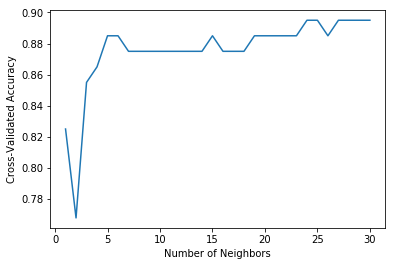

Using k = 24
預測結果： [0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1.
 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1.]
實際答案： [1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1.]
準確率： 0.7804878048780488


In [0]:
x_chi2 = preprocessing.scale(x_chi2)
x_train, x_test, y_train, y_test = train_test_split(x_chi2, hero_y, test_size=0.3) 

k_range = range(1, 31)
k_scores = []
for k_number in k_range:
    knn = KNeighborsClassifier(n_neighbors=k_number)
    scores = cross_val_score(knn, x_train, y_train, cv=10, scoring='accuracy') 
    k_scores.append(scores.mean())

plt.plot(k_range, k_scores)
plt.xlabel('Number of Neighbors')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

max_k = k_scores.index( max(k_scores) ) + 1
knn = KNeighborsClassifier(n_neighbors=max_k).fit(x_train, y_train)
print("Using k =", max_k)
print("預測結果：", knn.predict(x_test))
print("實際答案：", y_test)
print("準確率：", knn.score(x_test, y_test))

### 利用 `ExtraTreesClassifier` 模型選擇特徵

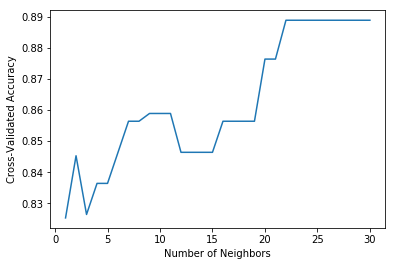

Using k = 22
預測結果： [1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0.]
實際答案： [1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.]
準確率： 0.8780487804878049


In [0]:
x_et = preprocessing.scale(x_et)
x_train, x_test, y_train, y_test = train_test_split(x_et, hero_y, test_size=0.3) 

k_range = range(1, 31)
k_scores = []
for k_number in k_range:
    knn = KNeighborsClassifier(n_neighbors=k_number)
    scores = cross_val_score(knn, x_train, y_train, cv=10, scoring='accuracy') 
    k_scores.append(scores.mean())

plt.plot(k_range, k_scores)
plt.xlabel('Number of Neighbors')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

max_k = k_scores.index( max(k_scores) ) + 1
knn = KNeighborsClassifier(n_neighbors=max_k).fit(x_train, y_train)
print("Using k =", max_k)
print("預測結果：", knn.predict(x_test))
print("實際答案：", y_test)
print("準確率：", knn.score(x_test, y_test))

### 利用 Linear SVC 模型選擇特徵

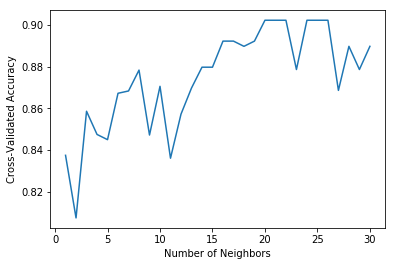

Using k = 20
預測結果： [1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1.
 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1.]
實際答案： [1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0.
 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.]
準確率： 0.7317073170731707


In [0]:
x_lsvc = preprocessing.scale(x_lsvc)
x_train, x_test, y_train, y_test = train_test_split(x_lsvc, hero_y, test_size=0.3) 

k_range = range(1, 31)
k_scores = []
for k_number in k_range:
    knn = KNeighborsClassifier(n_neighbors=k_number)
    scores = cross_val_score(knn, x_train, y_train, cv=10, scoring='accuracy') 
    k_scores.append(scores.mean())

plt.plot(k_range, k_scores)
plt.xlabel('Number of Neighbors')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

max_k = k_scores.index( max(k_scores) ) + 1
knn = KNeighborsClassifier(n_neighbors=max_k).fit(x_train, y_train)
print("Using k =", max_k)
print("預測結果：", knn.predict(x_test))
print("實際答案：", y_test)
print("準確率：", knn.score(x_test, y_test))

由於我們的資料集數量很少，而且由於資料在每一項測試中均重新分割訓練集/測試集（理論上若要做嚴謹的測試，每項測試所使用的訓練集/測試集**必須要相同**），**以上結果僅供參考**，僅提供同學們展示如何使用 Scikit-learn 中的功能，對於嚴謹的實驗有興趣的同學，歡迎自行上網搜尋，或諮詢你身邊的大學教授們！

### 同場加映：未經標準化的資料

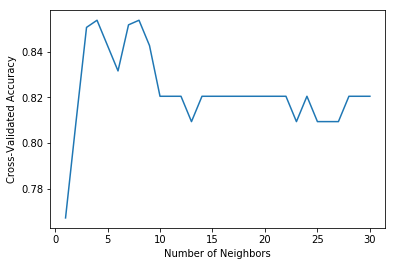

Using k = 4
預測結果： [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1.
 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0.]
實際答案： [0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0.]
準確率： 0.7073170731707317


In [0]:
x_train, x_test, y_train, y_test = train_test_split(hero_x, hero_y, test_size=0.3) 

k_range = range(1, 31)
k_scores = []
for k_number in k_range:
    knn = KNeighborsClassifier(n_neighbors=k_number)
    scores = cross_val_score(knn, x_train, y_train, cv=10, scoring='accuracy') 
    k_scores.append(scores.mean())

plt.plot(k_range, k_scores)
plt.xlabel('Number of Neighbors')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

max_k = k_scores.index( max(k_scores) ) + 1
knn = KNeighborsClassifier(n_neighbors=max_k).fit(x_train, y_train)
print("Using k =", max_k)
print("預測結果：", knn.predict(x_test))
print("實際答案：", y_test)
print("準確率：", knn.score(x_test, y_test))

**結果也是僅供參考**唷！:P